# Optimization model

---
Import the libraries

In [92]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Dataset

---
Step 1: Import the dataset (input.xlsx)

In [93]:
data = pd.read_excel('input.xlsx', None)

Setp 2: Assign the dataset into respective variables

In [94]:
T_start = [5,6]
T_end = [22,21]
alpha = [150,150]
gama = 12
C_bat = [350,350]
P = [0.1,0.05,0.05,0.05,0.05,0.07,0.12,0.12,0.14,0.2,0.075,0.075,0.075,0.1,0.1,0.2,0.1,0.15,0.09,0.01,0.05,0.7,0.2,0.1]
ch_eff = 0.9
E_0 = 0.2
E_max = 1
E_min = 0.2
E_end = 0.2
delta_t = 1
T = 24
t = len(P)
k = len(C_bat)
n = len(alpha)
i = len(T_start)

'''
T_start = data['Dataset']['Trip Begin'].tolist()
T_start = [int(x) for x in T_start]
T_end = data['Dataset']['Trip End'].tolist()
T_end = [int(x) for x in T_end]
alpha = data['Dataset']['Charger'].tolist()
gama = data['Dataset']['Energy consumption'].tolist()
gama = gama[0]
C_bat = data['Dataset']['Buses'].tolist()
P = data['Energy Price']['Buy']
ch_eff = 0.9
E_0 = 0.2
E_max = 1
E_min = 0.2
E_end = 0.2
delta_t = 0.25
T = 96
t = len(P)
k = len(C_bat)
n = len(alpha)
i = len(T_start)
'''

"\nT_start = data['Dataset']['Trip Begin'].tolist()\nT_start = [int(x) for x in T_start]\nT_end = data['Dataset']['Trip End'].tolist()\nT_end = [int(x) for x in T_end]\nalpha = data['Dataset']['Charger'].tolist()\ngama = data['Dataset']['Energy consumption'].tolist()\ngama = gama[0]\nC_bat = data['Dataset']['Buses'].tolist()\nP = data['Energy Price']['Buy']\nch_eff = 0.9\nE_0 = 0.2\nE_max = 1\nE_min = 0.2\nE_end = 0.2\ndelta_t = 0.25\nT = 96\nt = len(P)\nk = len(C_bat)\nn = len(alpha)\ni = len(T_start)\n"

## Programming the Opt model

---

### Step 1: Define the model

In [95]:
model = pyo.ConcreteModel()

### Step 2: Define the ranges

In [96]:
#ranges
model.I = pyo.RangeSet(i) # set of trips
model.T = pyo.RangeSet(t) # set of timesteps
model.K = pyo.RangeSet(k) # set of buses
model.N = pyo.RangeSet(n) # set of chargers

### Step 3: Define the parameters

In [97]:
#parameters
model.T_start = pyo.Param(model.I, initialize=lambda model, i: T_start[i-1]) # start time of trip i
model.T_end = pyo.Param(model.I, initialize=lambda model, i: T_end[i-1]) # end time of trip i
model.alpha = pyo.Param(model.N, initialize=lambda model, n: alpha[n-1]) # charging power of charger n
model.ch_eff = pyo.Param(initialize=ch_eff) # charging efficiency of charger n
model.gama = pyo.Param(initialize=gama) # energy consumption
model.P = pyo.Param(model.T, initialize=lambda model, t: P[t-1]) # electricity purchasing price in time t
model.E_0 = pyo.Param(initialize=E_0) # initial energy level of bus k
model.E_min = pyo.Param(initialize=E_min) # minimum energy level allowed for bus k
model.E_max = pyo.Param(initialize=E_max) # maximum energy level allowed for bus k
model.E_end = pyo.Param(initialize=E_end) # minimum energy after an operation day for bus k
model.C_bat = pyo.Param(model.K, initialize=lambda model, k: C_bat[k-1]) # total capacity of the bus k battery

### Step 4: Define the variables

In [98]:
#binary variables
model.b = pyo.Var(model.K,model.I, model.T, within=pyo.Binary) # binary variable indicating if bus k is serving trip i at time t
model.x = pyo.Var(model.K, model.N, model.T, domain=pyo.Binary) # binary variable indicating if bus k is occupying a charger n at time t to charge
model.c = pyo.Var(model.K, model.T, domain=pyo.Binary) # binary variable indicating if bus k is charging/discharging at time t

#non-negative variables
model.e = pyo.Var(model.K, model.T, within=pyo.NonNegativeReals) # energy level of bus k at time t
model.w_buy = pyo.Var(model.T, within=pyo.NonNegativeReals) # electricity purchased from the grid at time t

### Step 5: Define the objective function

In [99]:
#objective function
def rule_obj(mod):
    return sum(mod.P[t]*mod.w_buy[t] for t in mod.T)
model.obj = pyo.Objective(rule=rule_obj, sense=pyo.minimize)

#### Step 6: Define the constraints

In [100]:
#constraints
model.constraints = pyo.ConstraintList()  # Create a set of constraints

#constraint 1
for k in model.K:
    for t in model.T:
        model.constraints.add(sum(model.b[k,i,t] for i in model.I) + sum(model.x[k,n,t] for n in model.N) <=1)

#constraint 2
for n in model.N:
    for t in model.T:
        model.constraints.add(sum(model.x[k,n,t] for k in model.K) <= 1)

#constraint 3
for i in model.I: 
    for t in range(model.T_start[i],model.T_end[i]):
        model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 1)

    for t in range(1,model.T_start[i]):
        model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 0)

    for t in range(model.T_end[i],T+1):
        model.constraints.add(sum(model.b[k,i,t] for k in model.K) == 0)

#constraint 4
for i in model.I:
    for k in model.K:
        for t in range(model.T_start[i],model.T_end[i]-1):
            model.constraints.add(model.b[k,i,t+1] >= model.b[k,i,t])

#constraint 5
for k in model.K:
    for t in range(2,T+1):
        model.constraints.add(model.e[k,t] == model.e[k,t-1] + sum(delta_t * model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N) - sum(model.gama * model.b[k,i,t] for i in model.I))

#constraint 6
for t in model.T:
    model.constraints.add(sum(delta_t * model.ch_eff*model.alpha[n]*model.x[k,n,t] for n in model.N for k in model.K) == model.w_buy[t])

#constraint 7
for k in model.K:
    for t in model.T:
        model.constraints.add(model.e[k,t] >= model.C_bat[k] * model.E_min)

#constraint 8
for k in model.K:
    for t in model.T:
        model.constraints.add(E_max * model.C_bat[k] >= model.e[k,t])          

#constraint 9
for k in model.K:
    model.constraints.add(model.e[k,1] == model.E_0*model.C_bat[k])

#constraint 10
for k in model.K:
    model.constraints.add(model.e[k,T] >= model.E_end*model.C_bat[k])  

### Step 7: Solve the model

In [101]:
opt = pyo.SolverFactory('glpk')
#opt.options['timelimit'] = 60
#opt.options['mipgap'] = 0.01
results = opt.solve(model,tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmpiitp1u_e.glpk.raw
 --wglp /var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmpzvzqmzmh.glpk.glp
 --cpxlp /var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmptv5xo30s.pyomo.lp
Reading problem data from '/var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmptv5xo30s.pyomo.lp'...
/var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmptv5xo30s.pyomo.lp:2420: warning: lower bound of variable 'x27' redefined
/var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmptv5xo30s.pyomo.lp:2420: warning: upper bound of variable 'x27' redefined
374 rows, 264 columns, 1000 non-zeros
192 integer variables, all of which are binary
2612 lines were read
Writing problem data to '/var/folders/bs/tqpdfpm95n9c4cp994_d9lm00000gn/T/tmpzvzqmzmh.glpk.glp'...
2025 lines were written
GLPK Integer Optimizer 5.0
374 rows, 264 columns, 1000 non-zeros
192 integer variables, all of which are bina

## Results and Vizualization

---

In [102]:
print('The objective function values is:', model.obj())
print(results)

The objective function values is: 27.0

Problem: 
- Name: unknown
  Lower bound: 27.0
  Upper bound: 27.0
  Number of objectives: 1
  Number of constraints: 374
  Number of variables: 264
  Number of nonzeros: 1000
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 751
      Number of created subproblems: 751
  Error rc: 0
  Time: 0.11687326431274414
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## Plotting and assessing the results

Defining the plot functions

In [103]:
def plot_energy(K,T,e):
    bus_list = []
    energy_list = []
    for k in K:
        bus_number = 'bus' + ' ' + str(k)
        bus_list.append(bus_number)
    for t in T:
        for  k in K:
            energy_list.append(pyo.value(e[k,t]))
    energy_array = np.reshape(energy_list, (len(T), len(bus_list)))
    Energy = pd.DataFrame(energy_array,index=T, columns=bus_list)
    Energy_perc = (Energy*100)/C_bat[0]
    Energy_perc.plot(figsize=(12,6))
    plt.xlabel('Time [min]')
    plt.ylabel('State of Charge [%]')
    return Energy, Energy_perc

def plot_power(T,w):
    transac_list = []
    for t in T:
        value = pyo.value(w[t])
        transac_list.append(value)
    Power = pd.DataFrame(transac_list, index=T, columns=['Power'])*4
    Power.plot(figsize=(12,6))
    plt.xlabel('Time [min]')
    plt.ylabel('Power [kWh]')
    return Power

Vizualization of the results

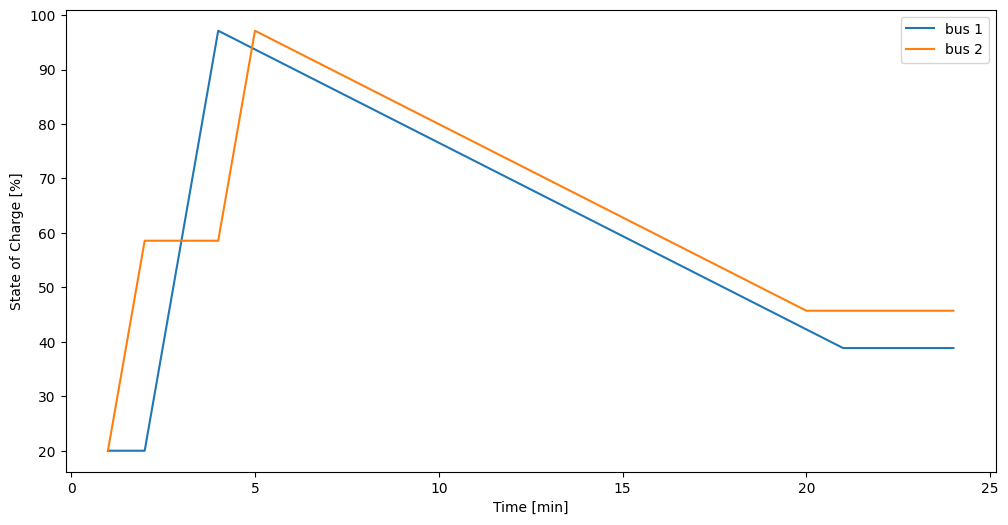

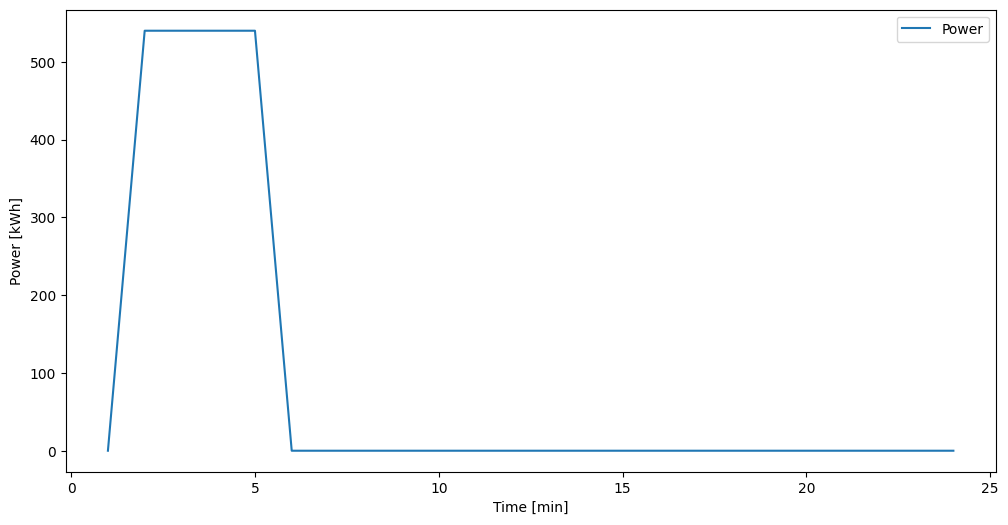

In [104]:
energy, energy_perc = plot_energy(model.K,model.T,model.e)
power = plot_power(model.T,model.w_buy)


In [105]:
energy.describe()

,bus 1,bus 2
count,24.000000,24.000000
mean,209.875000,221.875000
std,77.888612,66.217896
min,70.000000,70.000000
25%,145.000000,169.000000
50%,206.500000,206.500000
75%,271.000000,271.000000
max,340.000000,340.000000


In [106]:
energy_perc.describe()

,bus 1,bus 2
count,24.000000,24.000000
mean,59.964286,63.392857
std,22.253889,18.919399
min,20.000000,20.000000
25%,41.428571,48.285714
50%,59.000000,59.000000
75%,77.428571,77.428571
max,97.142857,97.142857


In [107]:
power.describe()

,Power
count,24.000000
mean,90.000000
std,205.574487
min,-0.000000
25%,-0.000000
50%,-0.000000
75%,0.000000
max,540.000000
